# Introduction
- This notebook presents Python code for the algorithm described in https://www.researchgate.net/publication/320864673_A_simple_algorithm_to_find_all_real_roots_of_a_polynomial. Please cite this paper if you use this code or part of it.
- The code finds all real roots of a polynomial, using standard floating point arithmetics.
- A companion notebook presents Python code for the same algorithm, using mpmath for arbitrary precision arithmetics.
- You may also read the *Fundamentals* notebook in this repository.
- This notebook contains code and tests using some notorious polynomials

# Code
Notes:
- Sympy polynomials and some associated functions are used only for the construction of polynomials for testing, and also for checking correctness of the number or roots found.

## Solver

In [50]:
from collections import OrderedDict


def sign(value):
    if value < 0:
        return -1
    elif value == 0:
        return 0
    return 1

def degree(p):
    return len(p) - 1

def p_to_str(p):
    
    n = len(p) - 1
    s = str(p[0]) + 'x' + str(n)

    for i in range(1, n+1):
        if p[i] > 0:
            s += ' + ' + str(p[i]) + 'x' + str(n-i)
        elif p[i] < 0:
            s += ' - ' + str(-p[i]) + 'x' + str(n-i)
    
    return s

def derivative(p):
    n = len(p)
    return [p[i]*(n-i-1) for i in range(n-1)]

def evaluate(p, x_value):
    # Using Horner method
    result = p[0]
    for coef in p[1:]:
        result = result*x_value + coef
    return result

def bisection(a, b, tolerance, p, pdiff):
    '''
    Classical bisection method. 
    Raises ValueError when a no progress situation is detected
    pdiff parameter exists only to keep the same signature as other bracketing
    methods, such as Newton-Raphson, that uses the derivative of p
    '''    
    p_a = evaluate(p, a)
    p_b = evaluate(p, b)
    m = (a + b) / 2
    p_m = evaluate(p, m)
    progress = True
    
    iter = 0
    while (abs(p_m) > tolerance or b - a > tolerance) and progress:
        iter += 1
        old_a, old_b = a, b
        if p_a * p_m <= 0:
            b = m
            p_b = p_m
        elif p_b * p_m <= 0:
            a = m
            p_a = p_m
        m = (a + b) / 2
        p_m = evaluate(p, m)
        if old_a == a and old_b == b:
            progress = False
            raise ValueError(f'bissection: no progress after {iter} iterations\n' 
                             f'while isolating a root of {p_to_str(p)} \nwith \na = {a} \nb = {b}')
    return m

def internal_root(p, pdiff, roots_dict, derivative_roots_dict,
                  a, b, tolerance, bracketing):
    print(f'internal_root: looking for a root in interval ({a}, {b}]')
    p_a = evaluate(p, a)
    if abs(p_a) <= tolerance:
        print(f'p({a}) = {p_a}; {a} is a root, so there are no roots in interval ({a}, {b}]')
    else:
        p_b = evaluate(p, b)

        if abs(p_b) <= tolerance:
            print(f'p({b}) = {p_b}; {b} is a root')
            roots_dict[b] = derivative_roots_dict[b] + 1
            # Increment multiplicity
        else:
            print(f'p({b}) = {p_b}; {b} is not a root')
            sign_at_a = sign(p_a)
            sign_at_b = sign(p_b)
            if sign_at_a == sign_at_b:
                pass
            else:
                roots_dict[bracketing(a, b, tolerance, p, pdiff)] = 1


def external_root(p, pdiff, roots_dict, derivative_roots_dict,
                  extremity, limit_sign, initial_step, tolerance, bracketing):
    '''
    extremity is the smallest or largest root of pdiff.
    If initial_step < 0, this function will look for a root in interval (-inf, extremity];
    If initial_step > 0, this function will look for a root in interval (extremity, inf)
    '''
    
    if initial_step < 0:
        print(f'external_root: looking for a root in interval (-inf, {extremity}]')
    else:
        print(f'external_root: looking for a root in interval ({extremity}, inf)')
        
    def point_with_sign_inversion(p, extremity, sign_at_extremity, initial_step):

        step = initial_step
        x = extremity + step
        p_x = evaluate(p, x)
        sign_at_x = sign(p_x)

        while sign_at_x == sign_at_extremity:
            step = 2*step # Double step length
            x = x + step
            p_x = evaluate(p, x)
            sign_at_x = sign(p_x)

        return x 

    value_at_extremity = evaluate(p, extremity)
    
    if abs(value_at_extremity) <= tolerance:
        if initial_step < 0:
            roots_dict[extremity] = derivative_roots_dict[extremity] + 1
            # increment multiplicity
    else:
        sign_at_extremity = sign(value_at_extremity)
        if limit_sign != sign_at_extremity:
            if initial_step > 0:
                a = extremity
                b = point_with_sign_inversion(p, extremity, 
                                              sign_at_extremity, initial_step)
            else:
                a = point_with_sign_inversion(p, extremity, 
                                              sign_at_extremity, initial_step)
                b = extremity

            roots_dict[bracketing(a, b, tolerance, p, pdiff)] = 1
            # multiplicity = 1

def roots_from_derivative_roots(p, derivative_roots_dict, tolerance, bracketing):
    '''
    Returns an OrderedDict, with roots as keys and multiplicity as values
    '''
    roots_dict = OrderedDict()
    
    derivative_roots = [r[0] for r in derivative_roots_dict.items()]
    n_derivative_roots = len(derivative_roots)
    pdiff = derivative(p)
       
    if n_derivative_roots == 0:
        # I took 0, but any point should work
        left_extremity = 0
        right_extremity = 0
    else:
        left_extremity = derivative_roots[0]
        right_extremity = derivative_roots[-1]
    
    right_limit_sign = sign(p[0]) # p[0]: Leading Coefficient
       
    if degree(p) % 2 == 0:
        left_limit_sign = sign(p[0])
    else:
        left_limit_sign = -sign(p[0]) 
    
    external_root(p, pdiff, roots_dict, derivative_roots_dict,
                  left_extremity, left_limit_sign, -1, 
                  tolerance, bracketing)
    
    for i in range(n_derivative_roots - 1): 
        internal_root(p, pdiff, roots_dict, derivative_roots_dict,
                      derivative_roots[i], derivative_roots[i+1], 
                      tolerance, bracketing)
         
    external_root(p, pdiff, roots_dict, derivative_roots_dict,
                  right_extremity, right_limit_sign, 1, 
                  tolerance, bracketing)
    
    return roots_dict 

def find_real_roots(p, tolerance=1.0e-5, bracketing=bisection, level=0):
    '''
     Find real roots of polynomial defined by list p
     If the length of p is n+1 then the polynomial is described by:
       p[0] * x**n + p[1] * x**(n-1) + ... + p[n-1]*x + p[n]
    '''
    roots_dict = OrderedDict()
    
    
    print(f'Solving {p_to_str(p)} = 0, level {level}')

    if len(p) == 2: 
        # first degree polynomial
        roots_dict[-p[1]/p[0]] = 1
    else:
        derivative_roots_dict = find_real_roots(derivative(p), tolerance, bracketing, level=level+1)
        print(f'Returning to {p_to_str(p)}, level {level}\n')
        roots_dict = roots_from_derivative_roots(
            p, derivative_roots_dict,
            tolerance, bracketing)

    print(f'\n\n**** Roots of {p_to_str(p)}: {roots_dict}')
    
    check_roots(p, roots_dict, tolerance)
    print('\n\n')
    return roots_dict

## Checking roots

In [2]:
from sympy import Symbol, Poly, rem, LC, Rational
from sympy import degree as sp_degree

x = Symbol('x')

def sign_at_minus_inf(poly):

    if sp_degree(poly) % 2 == 0:
        s = sign(LC(poly, x))
    else:
        s = sign(-LC(poly, x))
        
    return s
    
def sign_at_plus_inf(poly):

    s = sign(LC(poly, x))

    return s

In [3]:
def Sturm(p):
    """
    Returns total number of distinct real roots of p, based on Sturm's theorem
    https://en.wikipedia.org/wiki/Sturm%27s_theorem
    """
    x = Symbol('x')
    poly = Poly(p, x)
    
    minus_inf_sign_inversions = 0
    plus_inf_sign_inversions = 0
    
    last_p = poly.diff()

    if sign_at_minus_inf(poly) != sign_at_minus_inf(last_p):
        minus_inf_sign_inversions += 1
    if sign_at_plus_inf(poly) != sign_at_plus_inf(last_p):
        plus_inf_sign_inversions += 1
        
    last_sign_at_minus_inf = sign_at_minus_inf(last_p)
    last_sign_at_plus_inf = sign_at_plus_inf(last_p)

    while sp_degree(last_p) > 0:
        next_p = -rem(poly, last_p)

        if sign_at_minus_inf(next_p) != last_sign_at_minus_inf:
            minus_inf_sign_inversions += 1
        if sign_at_plus_inf(next_p) != last_sign_at_plus_inf:
            plus_inf_sign_inversions += 1
        poly = last_p
        last_p = next_p
        last_sign_at_minus_inf = sign_at_minus_inf(last_p)
        last_sign_at_plus_inf = sign_at_plus_inf(last_p)        
        
    return minus_inf_sign_inversions - plus_inf_sign_inversions

In [4]:
def check_roots(p, roots_dict, tolerance):
    
    roots = [r[0] for r in roots_dict.items()]
    
    # Are all elements of roots distinct and in ascending order?
    for i in range(len(roots) - 1):
        if roots[i] >= roots[i + 1]:
            raise ValueError(f'roots[{i}] is >= roots[{i + 1}]')
    print(f'\ncheck_roots: all roots are distinct and in order')
    # For all r in roots, abs(p(r)) <= tolerance?

    for r in roots:
        if abs(evaluate(p, r)) > tolerance:
            raise ValueError(f'abs(p({r})) = {abs(evaluate(p, r))} > {tolerance}')
    print(f'check_roots: all roots are roots within tolerance')
    # Number of elements of roots equals Sturm(p)?
    n_roots_Sturm = Sturm(p)
    if len(roots) != n_roots_Sturm:
        print(f">>> ERROR: Only {len(roots)} real roots found; "
                         f"{n_roots_Sturm} real roots were expected by Sturm's theorem.")
    else:
        print(f"check_roots: number of real roots, {n_roots_Sturm},"
              " as expected by Sturm's theorem")

## Ploting polynomials

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_p(p, xlim):
    """
    Plots a polynomial
    """
    x_values = np.linspace(xlim[0], xlim[1], 200)
    #print(f'v = {v}')
    y_p = [evaluate(p, v) for v in x_values]
    
    ax = plt.gca()

    plt.gcf().text(0.02, -0.1, '$' + p_to_str(p) + '$', fontsize=11)
    

    ax.plot(x_values, y_p, 'b')

    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    
    plt.show()

# Tests

## Polynomials with known roots
- Knowing the roots makes testing easier

In [6]:
def poly_from_roots(poly_roots, constant=Rational(1)):
    """
    Constructs a polynomial from a list of is roots. 
    If poly_roots contains a complex number, its conjugate will be included too.
    """
    x = Symbol('x')
    W = constant
    for r in poly_roots:
        if isinstance(r, complex):
            a = Rational(r.real)
            b = Rational(r.imag)
            W = W * (a**2 - 2*a*x + b**2 + x**2)
        else:
            W = W * (x - Rational(r))
    return [int(coef) for coef in Poly(W).all_coeffs()]

### A polynomial with 4 real roots

1*x^4 - 10*x^3 + 17*x^2 + 40*x^1 - 84*x^0


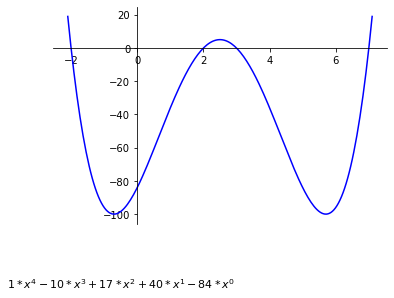

In [18]:
p = poly_from_roots([3, 2, -2, 7])
print(p_to_str(p))
plot_p(p, [-2.1, 7.1])

In [36]:
tolerance = 1.0e-7
roots_dict = find_real_roots(p, tolerance=tolerance, bracketing=bisection)
roots_dict

Solving 1*x^4 - 10*x^3 + 17*x^2 + 40*x^1 - 84*x^0 = 0, level 0
Solving 4*x^3 - 30*x^2 + 34*x^1 + 40*x^0 = 0, level 1
Solving 12*x^2 - 60*x^1 + 34*x^0 = 0, level 2
Solving 24*x^1 - 60*x^0 = 0, level 3


**** Roots of 24*x^1 - 60*x^0: OrderedDict([(2.5, 1)])

check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 1, as expected by Sturm's theorem



Returning to 12*x^2 - 60*x^1 + 34*x^0, level 2

external_root: looking for a root in interval (-inf, 2.5]
external_root: looking for a root in interval (2.5, inf)


**** Roots of 12*x^2 - 60*x^1 + 34*x^0: OrderedDict([(0.6515772491693497, 1), (4.34842275083065, 1)])

check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 2, as expected by Sturm's theorem



Returning to 4*x^3 - 30*x^2 + 34*x^1 + 40*x^0, level 1

external_root: looking for a root in interval (-inf, 0.6515772491693497]
int

OrderedDict([(-2.0, 1),
             (1.999999998547336, 1),
             (2.9999999985474073, 1),
             (7.0, 1)])

In [ ]:
check_roots(p, roots_dict, tolerance)

### A polynomial with real  and complex roots

1x8 - 70*x^7 + 1126*x^6 + 25210*x^5 - 88631*x^4 - 1622840*x^3 + 4914444*x^2 + 6092480*x^1 - 18312000*x^0


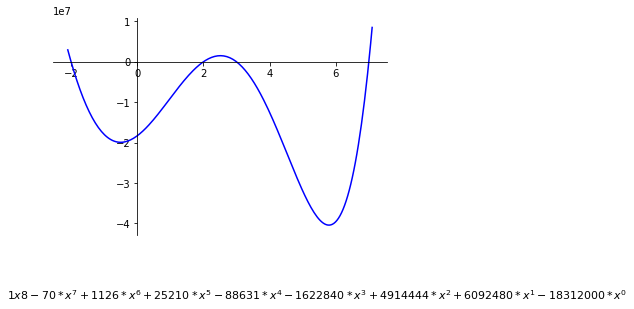

In [40]:
p = poly_from_roots([3, 2, -2, 7, 40 + 20j, -10 -3j])
print(p_to_str(p))
plot_p(p, [-2.1, 7.1])

In [42]:
tolerance = 1.0e-6
roots_dict = find_real_roots(p, tolerance=tolerance, bracketing=bisection)
roots_dict

Solving 1x8 - 70x7 + 1126x6 + 25210x5 - 88631x4 - 1622840x3 + 4914444x2 + 6092480x1 - 18312000x0 = 0, level 0
Solving 8x7 - 490x6 + 6756x5 + 126050x4 - 354524x3 - 4868520x2 + 9828888x1 + 6092480x0 = 0, level 1
Solving 56x6 - 2940x5 + 33780x4 + 504200x3 - 1063572x2 - 9737040x1 + 9828888x0 = 0, level 2
Solving 336x5 - 14700x4 + 135120x3 + 1512600x2 - 2127144x1 - 9737040x0 = 0, level 3
Solving 1680x4 - 58800x3 + 405360x2 + 3025200x1 - 2127144x0 = 0, level 4
Solving 6720x3 - 176400x2 + 810720x1 + 3025200x0 = 0, level 5
Solving 20160x2 - 352800x1 + 810720x0 = 0, level 6
Solving 40320x1 - 352800x0 = 0, level 7


**** Roots of 40320x1 - 352800x0: OrderedDict([(8.75, 1)])

check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 1, as expected by Sturm's theorem



Returning to 20160x2 - 352800x1 + 810720x0, level 6

external_root: looking for a root in interval (-inf, 8.75]
external_root: looking for a root in interv

OrderedDict([(-2.0000000000000036, 1),
             (1.9999999999999092, 1),
             (2.999999999999938, 1),
             (6.999999999999993, 1)])

In [ ]:
check_roots(p, roots_dict, tolerance)

### A polynomial with only complex roots

1x8 - 20x7 + 200x6 - 1200x5 + 4708x4 - 12080x3 + 20000x2 - 19200x1 + 9216x0


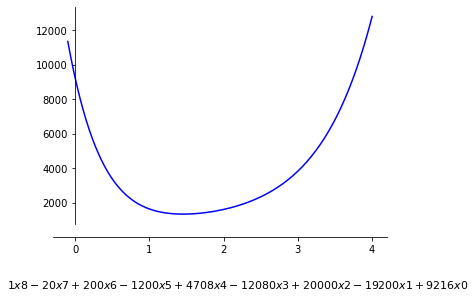

In [43]:
p = poly_from_roots([1 + 1j, 2 + 2j, 3 + 3j, 4 + 4j])
print(p_to_str(p))
plot_p(p, [-0.1, 4])

In [44]:
tolerance = 1.0e-6
roots_dict = find_real_roots(p, tolerance=tolerance, bracketing=bisection)
roots_dict

Solving 1x8 - 20x7 + 200x6 - 1200x5 + 4708x4 - 12080x3 + 20000x2 - 19200x1 + 9216x0 = 0, level 0
Solving 8x7 - 140x6 + 1200x5 - 6000x4 + 18832x3 - 36240x2 + 40000x1 - 19200x0 = 0, level 1
Solving 56x6 - 840x5 + 6000x4 - 24000x3 + 56496x2 - 72480x1 + 40000x0 = 0, level 2
Solving 336x5 - 4200x4 + 24000x3 - 72000x2 + 112992x1 - 72480x0 = 0, level 3
Solving 1680x4 - 16800x3 + 72000x2 - 144000x1 + 112992x0 = 0, level 4
Solving 6720x3 - 50400x2 + 144000x1 - 144000x0 = 0, level 5
Solving 20160x2 - 100800x1 + 144000x0 = 0, level 6
Solving 40320x1 - 100800x0 = 0, level 7


**** Roots of 40320x1 - 100800x0: OrderedDict([(2.5, 1)])

check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 1, as expected by Sturm's theorem



Returning to 20160x2 - 100800x1 + 144000x0, level 6

external_root: looking for a root in interval (-inf, 2.5]
external_root: looking for a root in interval (2.5, inf)


**** Roots of 20160x2 - 10080

OrderedDict()

In [ ]:
check_roots(p, roots_dict, tolerance)

### A polynomial with roots with multiplicity

1x10 - 38x9 + 637x8 - 6188x7 + 38452x6 - 159008x5 + 440512x4 - 800768x3 + 904192x2 - 565248x1 + 147456x0


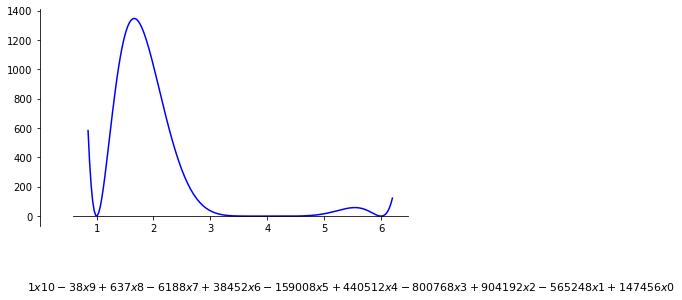

In [45]:
p = poly_from_roots([1]*2  + [4]*6 + [6]*2)
print(p_to_str(p))
plot_p(p, [0.85, 6.2])

In [52]:
tolerance = 1.0e-6
roots_dict = find_real_roots(p, tolerance=tolerance, bracketing=bisection)

Solving 1x10 - 38x9 + 637x8 - 6188x7 + 38452x6 - 159008x5 + 440512x4 - 800768x3 + 904192x2 - 565248x1 + 147456x0 = 0, level 0
Solving 10x9 - 342x8 + 5096x7 - 43316x6 + 230712x5 - 795040x4 + 1762048x3 - 2402304x2 + 1808384x1 - 565248x0 = 0, level 1
Solving 90x8 - 2736x7 + 35672x6 - 259896x5 + 1153560x4 - 3180160x3 + 5286144x2 - 4804608x1 + 1808384x0 = 0, level 2
Solving 720x7 - 19152x6 + 214032x5 - 1299480x4 + 4614240x3 - 9540480x2 + 10572288x1 - 4804608x0 = 0, level 3
Solving 5040x6 - 114912x5 + 1070160x4 - 5197920x3 + 13842720x2 - 19080960x1 + 10572288x0 = 0, level 4
Solving 30240x5 - 574560x4 + 4280640x3 - 15593760x2 + 27685440x1 - 19080960x0 = 0, level 5
Solving 151200x4 - 2298240x3 + 12841920x2 - 31187520x1 + 27685440x0 = 0, level 6
Solving 604800x3 - 6894720x2 + 25683840x1 - 31187520x0 = 0, level 7
Solving 1814400x2 - 13789440x1 + 25683840x0 = 0, level 8
Solving 3628800x1 - 13789440x0 = 0, level 9


**** Roots of 3628800x1 - 13789440x0: OrderedDict([(3.8, 1)])

check_roots: all ro

OrderedDict([(0.9999999999952704, 2),
             (4.000000000022853, 6),
             (6.00000000004984, 2)])

In [53]:
# Same as above, with stricter tolerance.
# Fails because a root of the derivative, within tolerance, is not considered a root of the polynomial
# within the same tolerance
tolerance = 1.0e-7
roots_dict = find_real_roots(p, tolerance=tolerance, bracketing=bisection)

Solving 1x10 - 38x9 + 637x8 - 6188x7 + 38452x6 - 159008x5 + 440512x4 - 800768x3 + 904192x2 - 565248x1 + 147456x0 = 0, level 0
Solving 10x9 - 342x8 + 5096x7 - 43316x6 + 230712x5 - 795040x4 + 1762048x3 - 2402304x2 + 1808384x1 - 565248x0 = 0, level 1
Solving 90x8 - 2736x7 + 35672x6 - 259896x5 + 1153560x4 - 3180160x3 + 5286144x2 - 4804608x1 + 1808384x0 = 0, level 2
Solving 720x7 - 19152x6 + 214032x5 - 1299480x4 + 4614240x3 - 9540480x2 + 10572288x1 - 4804608x0 = 0, level 3
Solving 5040x6 - 114912x5 + 1070160x4 - 5197920x3 + 13842720x2 - 19080960x1 + 10572288x0 = 0, level 4
Solving 30240x5 - 574560x4 + 4280640x3 - 15593760x2 + 27685440x1 - 19080960x0 = 0, level 5
Solving 151200x4 - 2298240x3 + 12841920x2 - 31187520x1 + 27685440x0 = 0, level 6
Solving 604800x3 - 6894720x2 + 25683840x1 - 31187520x0 = 0, level 7
Solving 1814400x2 - 13789440x1 + 25683840x0 = 0, level 8
Solving 3628800x1 - 13789440x0 = 0, level 9


**** Roots of 3628800x1 - 13789440x0: OrderedDict([(3.8, 1)])

check_roots: all ro

### Wilkinson polynomials

In [ ]:
def Wilkinson(n):
    return poly_from_roots(list(range(1,n+1)))

In [ ]:
p = Wilkinson(10)
print(p_to_str(p))
plot_p(p, [0.95, 10.05])

In [ ]:
tolerance = 1.0e-6
roots_dict = find_real_roots(p, tolerance=tolerance)
roots_dict

In [ ]:
check_roots(p, roots_dict, tolerance)

In [ ]:
# Same as above, but with a scricter tolerance that will raise a ValueException
tolerance = 1.0e-7 
roots_dict = find_real_roots(p, tolerance=tolerance)
roots_dict

##  Mignotte polynomials

In [ ]:
def Mignotte(n, tau):
    x = Symbol('x')
    return [int(coef) for coef in Poly((x**n - ((2**(tau//2) - 1)*x - 1)**2)).all_coeffs()]

In [ ]:
p = Mignotte(7, 4)
plot_p(p, (-1, 1.5))

In [ ]:
tolerance = 1.0e-10
roots_dict = find_real_roots(p, tolerance=tolerance)
roots_dict

In [ ]:
check_roots(p, roots_dict, tolerance)

In [ ]:
p = Mignotte(11, 14)
plot_p(p, (-1, 3.1))

In [ ]:
tolerance = 1.0e-10
roots_dict = find_real_roots(p, tolerance=tolerance)
roots_dict

In [ ]:
check_roots(p, roots_dict, tolerance)

## Chebyshev polynomials of first kind

In [ ]:
def memoize(f):
    memo = {}
    def helper(x):
        if x not in memo:            
            memo[x] = f(x)
        return memo[x]
    return helper

@memoize
def Chebyshev(n):
    x = Symbol('x')
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return (2*x*Chebyshev(n-1) - Chebyshev(n-2)).expand()

In [ ]:
p = [int(coef) for coef in Poly(Chebyshev(12)).all_coeffs()]
plot_p(p, (-1.01, 1.01))
tolerance = 1.0e-5
roots_dict = find_real_roots(p, tolerance=tolerance)
roots_dict

In [ ]:
check_roots(p, roots_dict, tolerance)